# <i class="fas fa-star"></i>&hairsp;T07: Curvature Optimization with Automated Path Tracing


## Overview

This tutorial demonstrates how to use PySNT's A* path tracing capabilities to optimize neuronal reconstructions by re-tracing along waypoints through the original image data. This workflow is useful for:

- **Refining coarse reconstructions** obtained from automated segmentation pipelines
- **Improving manual tracings** by snapping paths to the underlying fluorescence signal
- **Assigning thickness** to skeletonized tracings lacking radius information
- **Generating high-fidelity ground truth** for training segmentation algorithms


```{admonition} Learning Objectives
:class: tip

By the end of this tutorial, you will be able to:
1. Perform headless A* auto-tracing between waypoints in fluorescent imagery
2. Programmatically optimize path trajectories to follow intensity ridges
3. Fit cross-sectional profiles to estimate neurite thickness
4. Quantitatively compare original and optimized reconstructions

**Estimated Time**: 45 minutes
```

```{note}
Make sure to read these resources before running this notebook:
- [Install](../install.md) - Installation instructions
- [Tutorial 01](./01_single_cell_analysis.ipynb) - Single cell analysis basics
- [Tutorial 05](./05_napari_viewer.ipynb) - Working with images and reconstructions
```

## Introduction

Neuronal reconstructions vary widely in detail and accuracy. Coarse reconstructions may capture overall topology but lack the fine curvature that follows actual neurite fluorescence. Conversely, we may want to validate whether an existing reconstruction faithfully follows the image signal. This tutorial demonstrates how to programmatically optimize path curvatures using A* search, an algorithm that finds optimal paths by balancing distance traveled against image intensity (aka _cost function_), ensuring traces follow actual neurite fluorescence. SNT provides several A* variants and cost functions; for simplicity, we will stick to the defaults here.

**Tutorial Rationale:**

We will validate the A* optimization workflow by:

1. **Degrading** a gold-standard reconstruction to a barebones minimum composed only of branch points and end points
2. **Retracing** paths between these anchor points using A* search through the original image
3. **Comparing** the retraced structure against the original to assess recovery of path curvatures

As ground truth, we use the **OP_1** dataset from the [DIADEM challenge](https://diadem.janelia.org/), previously introduced in [Tutorial 05](./05_napari_viewer.ipynb).

## Setup and Initialization

As always, we start by initializing pysnt with appropriate settings for notebook execution:

In [ ]:
import pysnt
pysnt.set_option('java.logging.level', 'Error')
pysnt.set_option('display.chart_format', 'svg')
pysnt.set_option('display.chart_dpi', 150)
pysnt.initialize()

We'll also need numpy for numerical operations and matplotlib for visualization:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Loading Data
Here we will use the *OP_1* demo dataset already used in [Tutorial 05](./05_napari_viewer.ipynb). We'll load both the reconstruction ({class}`pysnt.Tree`) and the source image using {class}`pysnt.SNTService`, as we have been doing since [Tutorial 01](./01_single_cell_analysis.ipynb):

In [3]:
from pysnt import SNTService

snt_service = SNTService()

# Load the ground-truth reconstruction
original_tree = snt_service.demoTree('OP1')
original_tree.setLabel('Original')

def print_info(tree):
    from pysnt.analysis import TreeStatistics
    print(f"Tree: {tree.getLabel()}")
    print(f"  No. of nodes: {tree.getNodes().size()}")
    stats = TreeStatistics(tree)
    print(f"  No. of branch points: {stats.getBranchPoints().size()}")
    print(f"  No. of tips: {stats.getTips().size()}")
    print(f"  Cable length: {stats.getCableLength():.2f} µm")

print_info(original_tree)

Tree: Original
  No. of nodes: 1544
  No. of branch points: 48
  No. of tips: 49
  Cable length: 746.40 µm


In [4]:
# Load the source image
img = snt_service.demoImage('OP1') # ImagePlus object

# Display some basic properties
print(f"Image: {img.getTitle()}")
print(f"  Dimensions: {img.getWidth()} x {img.getHeight()} x {img.getNSlices()}")
cal = img.getCalibration()
print(f"  Voxel size: {cal.pixelWidth} x {cal.pixelHeight} x {cal.pixelDepth} {cal.getUnit()}")

Image: OP_1.tif
  Dimensions: 512 x 512 x 60
  Voxel size: 0.32964852215271034 x 0.32964852215271034 x 0.9988 microns


Let's visualize the image its ground truth reconstruction:

## Obtaining Waypoints

To degrade the gold standard Tree we can use the `downsample()` method with a large internode spacing. Because branch points and endpoints are always preserved during downsampling, setting a very large spacing (e.g., 1 mm) effectively reduces the tree to just these critical points:

In [5]:
# Create a copy of the tree for simplification
degraded_tree = original_tree.clone()
degraded_tree.setLabel("Degraded Tree")

# Downsample with large spacing to retain only branch points and tips
# Branch points and end points are always preserved
degraded_tree.downsample(1000.0)  # 1000 µm spacing

Let's visualize the simplified structure alongside the original:

Tree: Degraded Tree
  No. of nodes: 146
  No. of branch points: 48
  No. of tips: 49
  Cable length: 669.05 µm


{'type': matplotlib.figure.Figure,
 'data': <Figure size 700x350 with 2 Axes>,
 'metadata': {'source_type': 'SNTChart_List',
  'sntchart_count': 2,
  'displayed_count': 2,
  'panel_layout': 'auto',
  'title': None},
 'error': None}

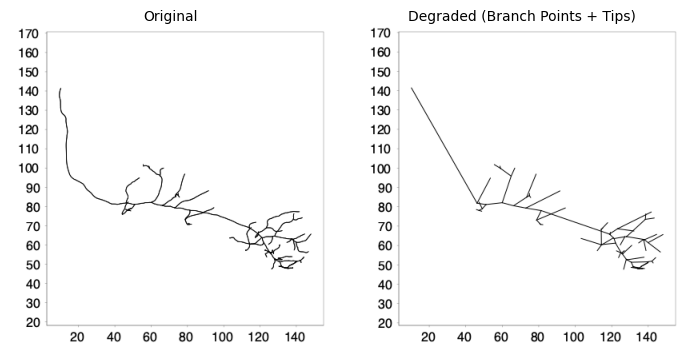

In [6]:
# Create side-by-side comparison
print_info(degraded_tree)
degraded_tree.setLabel("Degraded (Branch Points + Tips)")
pysnt.display([original_tree, degraded_tree], show_panel_titles=True)

## A* Tracing Between Waypoints

Now we use SNT's A* search to find optimal paths between consecutive anchor points through the image. The {class}`pysnt.SNT` class provides access to the tracing engine:


Tree: Degraded (Branch Points + Tips)
  No. of nodes: 146
  No. of branch points: 48
  No. of tips: 49
  Cable length: 669.05 µm


{'type': matplotlib.figure.Figure,
 'data': <Figure size 1050x350 with 3 Axes>,
 'metadata': {'source_type': 'SNTChart_List',
  'sntchart_count': 3,
  'displayed_count': 3,
  'panel_layout': (1, 3),
  'title': None},
 'error': None}

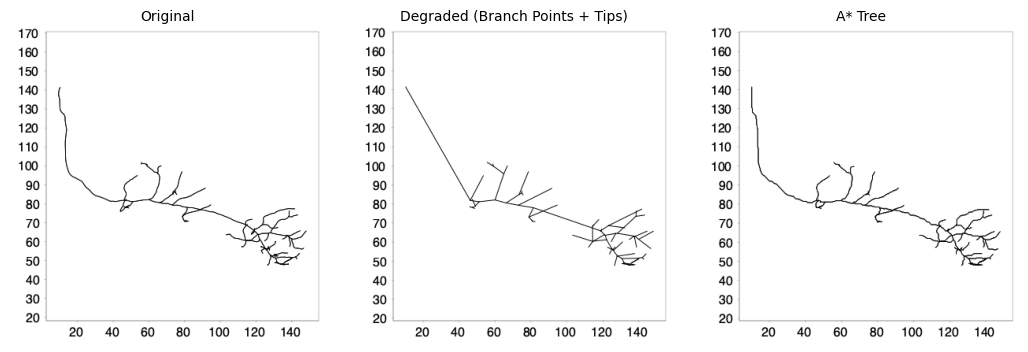

In [ ]:
def trace_between_anchors(img, simplified_tree):
    """
    Re-trace paths between waypoints using A* search.

    Parameters
    ----------
    img : ImagePlus or ImgPlus
        Image to be traced
    simplified_tree : Tree
        Tree containing waypoints

    Returns
    -------
    Tree
        New tree with paths traced through the image
    """
    from pysnt import Tree, SNT
    snt = SNT(img)
    traced_tree = simplified_tree.clone()
    for path in traced_tree.list():
        nodes = path.getNodes()
        # This autoTrace call uses 3 arguments: list of waypoints,
        # branch point to a parent path (not used here), and
        # boolean flag for headless execution
        traced_path = snt.autoTrace(nodes, None, True)
        if traced_path is not None:
            path.replaceNodes(traced_path) # Replace nodes (fork points automatically adjusted)

    return traced_tree


traced_tree = trace_between_anchors(img, degraded_tree)
traced_tree.setLabel("A* Tree")
print_info(degraded_tree)
pysnt.display([original_tree, degraded_tree, traced_tree], panel_layout=(1,3), show_panel_titles=True)

We can overlay both reconstructions to better gauge their spatial overlap:

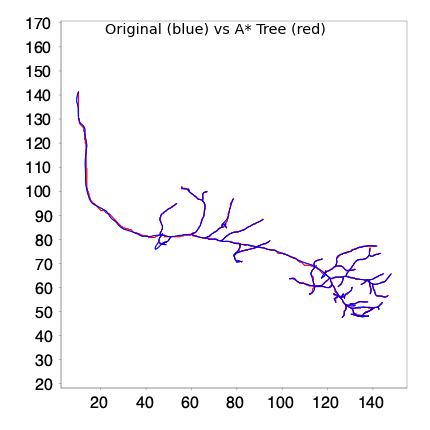

{'type': matplotlib.figure.Figure,
 'data': <Figure size 400x400 with 1 Axes>,
 'metadata': {'source_type': 'SNTChart',
  'format': 'svg',
  'scale': 1.0,
  'is_combined': False,
  'title': 'Reconstruction Plotter',
  'containsValidData': True,
  'isLegendVisible': True},
 'error': None}

In [8]:
# Overlay visualization with different colors
def overlay_trees(tree1, tree2):
    """Overlay two trees with different colors."""
    from pysnt.viewer import Viewer2D
    viewer = Viewer2D()
    tree1.setColor("blue")
    viewer.add(tree1)
    tree2.setColor("red")
    viewer.add(tree2)
    title = f"{tree1.getLabel()} (blue) vs {tree2.getLabel()} (red)"
    return pysnt.display(viewer, title = title)

overlay_trees(original_tree, traced_tree)

## Evaluation

To assess how well the retraced structure matches the original, we'll compute several similarity metrics to help us understand the spatial overlap and geometric similarity between the two trees. We will use [SciPy](https://scipy.org/) to compute:

1. **Jaccard Similarity**: Measures the overlap between two sets of points as the ratio of intersection to union
2. **Hausdorff Distance**: The maximum distance from any point in one set to the nearest point in the other set
3. **Cable Length Ratio**: Comparison of total cable lengths

In [9]:
from scipy.spatial.distance import directed_hausdorff
from scipy.spatial import cKDTree

def compute_jaccard_similarity(points1, points2, tolerance=1.0):
    """
    Compute Jaccard similarity between two point clouds.
    
    Points are considered overlapping if they are within the specified tolerance.
    
    Parameters
    ----------
    points1 : np.ndarray
        First point cloud (N, 3)
    points2 : np.ndarray
        Second point cloud (M, 3)
    tolerance : float
        Distance threshold for considering points as overlapping
    
    Returns
    -------
    float
        Jaccard similarity coefficient (0 to 1)
    """
    # Build KD-trees for efficient nearest neighbor queries
    tree1 = cKDTree(points1)
    tree2 = cKDTree(points2)
    
    # Find points in set1 that have a neighbor in set2 within tolerance
    distances1, _ = tree2.query(points1)
    overlap1 = np.sum(distances1 <= tolerance)
    
    # Find points in set2 that have a neighbor in set1 within tolerance
    distances2, _ = tree1.query(points2)
    overlap2 = np.sum(distances2 <= tolerance)
    
    # Jaccard: intersection / union
    # Intersection approximated as average of bidirectional overlaps
    intersection = (overlap1 + overlap2) / 2
    union = len(points1) + len(points2) - intersection
    
    return intersection / union if union > 0 else 0.0


def compute_hausdorff_distance(points1, points2):
    """
    Compute bidirectional Hausdorff distance between two point clouds.
    
    Parameters
    ----------
    points1 : np.ndarray
        First point cloud (N, 3)
    points2 : np.ndarray
        Second point cloud (M, 3)
    
    Returns
    -------
    float
        Hausdorff distance (maximum of both directed distances)
    """
    d1 = directed_hausdorff(points1, points2)[0]
    d2 = directed_hausdorff(points2, points1)[0]
    return max(d1, d2)


def compute_overlap_coefficient(points1, points2, tolerance=1.0):
    """
    Compute overlap coefficient (Szymkiewicz-Simpson) between two point clouds.
    
    The overlap coefficient is the size of intersection divided by the 
    size of the smaller set, ranging from 0 (no overlap) to 1 (smaller 
    set completely contained in larger).
    
    Parameters
    ----------
    points1 : np.ndarray
        First point cloud (N, 3)
    points2 : np.ndarray
        Second point cloud (M, 3)
    tolerance : float
        Distance threshold for considering points as overlapping
    
    Returns
    -------
    float
        Overlap coefficient (0 to 1)
    """
    tree2 = cKDTree(points2)
    distances, _ = tree2.query(points1)
    intersection = np.sum(distances <= tolerance)
    
    min_size = min(len(points1), len(points2))
    return intersection / min_size if min_size > 0 else 0.0


Now let's compute these metrics comparing the original tree to the traced result:

In [10]:


def comparison_report(original_tree, traced_tree):
    """Display comparison values between original and traced tree"""
    from pysnt.analysis import TreeStatistics

    print(f"Comparison Report:")

    # Extract point clouds: Extract node coordinates from Trees as numpy arrays
    original_points = pysnt.tree_to_points(original_tree)
    traced_points = pysnt.tree_to_points(traced_tree)
    
    # No. of nodes
    print(f"  Original tree: {len(original_points)} points")
    print(f"  Traced tree: {len(traced_points)} points")

    # Compute similarity metrics
    tolerance = 1.0  # µm, based on voxel size
    jaccard = compute_jaccard_similarity(original_points, traced_points, tolerance=tolerance)
    hausdorff = compute_hausdorff_distance(original_points, traced_points)
    overlap = compute_overlap_coefficient(original_points, traced_points, tolerance=tolerance)
    print(f"\nSimilarity Metrics (tolerance={tolerance} µm):")
    print(f"  Jaccard Similarity: {jaccard:.4f}")
    print(f"  Hausdorff Distance: {hausdorff:.2f} µm")
    print(f"  Overlap Coefficient: {overlap:.4f}")

    # Compare cable lengths using TreeStatistics
    stats_original = TreeStatistics(original_tree)
    stats_traced = TreeStatistics(traced_tree)
    cable_original = stats_original.getCableLength()
    cable_traced = stats_traced.getCableLength()
    print(f"\nCable Length Comparison:")
    print(f"  Original: {cable_original:.2f} µm")
    print(f"  Traced: {cable_traced:.2f} µm")
    print(f"  Ratio (traced/original): {cable_traced/cable_original:.4f}")

comparison_report(original_tree, traced_tree)

Comparison Report:
  Original tree: 1544 points
  Traced tree: 1661 points

Similarity Metrics (tolerance=1.0 µm):
  Jaccard Similarity: 0.9123
  Hausdorff Distance: 3.66 µm
  Overlap Coefficient: 0.9482

Cable Length Comparison:
  Original: 746.40 µm
  Traced: 844.01 µm
  Ratio (traced/original): 1.1308


## Refinement: Fitting to Signal

A* tracing recovers path topology, but node positions follow intensity ridges at voxel resolution. We can further refine the reconstruction by fitting cross-sectional intensity profiles perpendicular to each path tangent. This fitting procedure:

1. **Samples circular cross-sections** around each node, oriented normal to the local path direction
2. **Optimizes center position** by finding the intensity centroid within the cross-section
3. **Estimates node radius** by fitting a circle to the intensity profile

The [process](https://imagej.net/plugins/snt/manual#refinefit-) is multi-threaded, allowing paths to be fitted in parallel for efficient batch processing. Additionally, since fitting operates on a per-path basis, different paths can be fitted with different parameters if needed. 

In [11]:
from typing import Union

def fit_tree(img: Union['ImagePlus', 'ImgPlus'], 
             tree: 'Tree', 
             search_radius: float = 2, 
             workers: int = 4) -> 'Tree':
    """
    Fits circular cross-sections around path nodes to compute radii and refine centerline
    coordinates.
    
    Performs PathFitter operations on all paths in a tree using parallel processing.
    The fitting algorithm optimizes node positions and estimates node radii by 
    analyzing cross-sectional intensity profiles perpendicular to each path segment.
    
    Thread Safety:
        The fitting process is divided into two phases to maintain tree hierarchy:
        1. Parallel computation phase: Each path is fitted independently without modifying 
           the original path geometry (thread-safe)
        2. Sequential application phase: Fitted results are applied to paths one-by-one 
           to preserve parent-child relationships and branch point indices
    
    Parameters
    ----------
    img : ImagePlus or ImgPlus
        Should be a 2D or 3D image with the neuronal structure visible as bright 
        signal on dark background.
    tree : Tree
        The Tree object containing paths to be fitted. All paths in the tree will be 
        processed.
    search_radius : float, optional
        Maximum search radius in physical units for the fitting optimization. Defines 
        the neighborhood around each node where the algorithm searches for the optimal 
        cross-section. Default: 2 (µm)
    workers : int, optional
        Number of parallel worker threads for fitting. Default: 4.
    
    Returns
    -------
    Tree
        The input tree with all paths fitted in place (refined XYZ coordinates and
        estimated radius at each node (if successful)
    
    Notes
    -----
    Fitting Scope:
        - RADII_AND_MIDPOINTS: Both node positions and radii are optimized
        - Positions are refined by finding intensity-weighted centroids in cross-sections
        - Radii are estimated by fitting circles to intensity gradients in cross-sections
    
    Fallback Strategy:
        - FALLBACK_MODE: When fitting fails at a node, uses the mode (most common) 
          radius from nearby successful fits
        - Alternative strategies: FALLBACK_MIN_SEP (use voxel size) or FALLBACK_NAN
    """
    from pysnt import PathFitter
    from concurrent.futures import ThreadPoolExecutor
    
    def fit_path(path):
        """Configure and compute fit for a single path (thread-safe)."""
        fitter = PathFitter(img, path)
        
        # Fit both XYZ coordinates and radii using cross-sectional intensity analysis
        fitter.setScope(PathFitter.RADII_AND_MIDPOINTS) 
        
        # Constrain optimization to max_radius pixels around each node to:
        # 1) improve performance by limiting search space; and 2) avoid finding
        # spurious features far from the path
        fitter.setCrossSectionRadius(search_radius)
        
        # When optimization fails (e.g., low SNR, ambiguous geometry), use the mode
        # (most frequent) radius from nearby successful fits as a fallback
        fitter.setNodeRadiusFallback(PathFitter.FALLBACK_MODE)

        # Critical for thread safety: Execute fitting algorithm without modifying path
        # Replacing nodes modifies parent paths' geometry, which breaks branch point
        # indices for children being fitted simultaneously during parallel execution.
        # All fits will be applied sequentially _after_ parallel computation completes
        fitter.call() # returns a ref. to fitted path
        
        return fitter

    # Step 1: Parallel fitting (computation only, without modifying paths)
    with ThreadPoolExecutor(max_workers=workers) as executor:
        fitters = list(executor.map(fit_path, tree.list()))
    
    # Step 2: Sequential application (maintains tree hierarchy integrity)
    # Each applyFit() may update parent path geometry, so children's branch point
    # indices must be recalculated. Sequential execution ensures parent geometry
    # is finalized before children's branch points are updated.
    for fitter in fitters:
        fitter.setReplaceNodes(True) # in-place fit
        fitter.applyFit()
  
    return tree


# Runt fits on a traced_tree copy, setting the search radius to 1.5um
fitted_tree = fit_tree(img, traced_tree.clone(), search_radius=1.5)

Let's update the comparison report:

Comparison Report:
  Original tree: 1544 points
  Traced tree: 1167 points

Similarity Metrics (tolerance=1.0 µm):
  Jaccard Similarity: 0.9166
  Hausdorff Distance: 3.78 µm
  Overlap Coefficient: 1.2528

Cable Length Comparison:
  Original: 746.40 µm
  Traced: 865.40 µm
  Ratio (traced/original): 1.1594


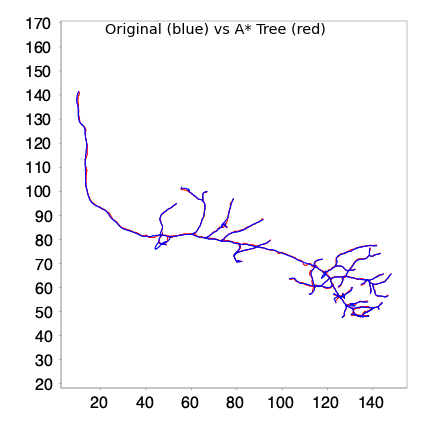

{'type': matplotlib.figure.Figure,
 'data': <Figure size 400x400 with 1 Axes>,
 'metadata': {'source_type': 'SNTChart',
  'format': 'svg',
  'scale': 1.0,
  'is_combined': False,
  'title': 'Reconstruction Plotter',
  'containsValidData': True,
  'isLegendVisible': True},
 'error': None}

In [12]:
comparison_report(original_tree, fitted_tree)
overlay_trees(original_tree, fitted_tree)

Path fitting yields a more efficient representation with improved spatial agreement.

The Jaccard similarity index increased, indicating better overlap despite fewer nodes. The slight increase in Hausdorff distance is not unexpected, as midpoint refinement can shift individual nodes toward local intensity maxima, occasionally increasing the maximum deviation at specific locations. The increased cable length ratio suggests that fitted paths may capture more faithfully fine curvatures that were previously approximated by straight segments between nodes.

Let's examine how the Jaccard similarity varies with different tolerance values:

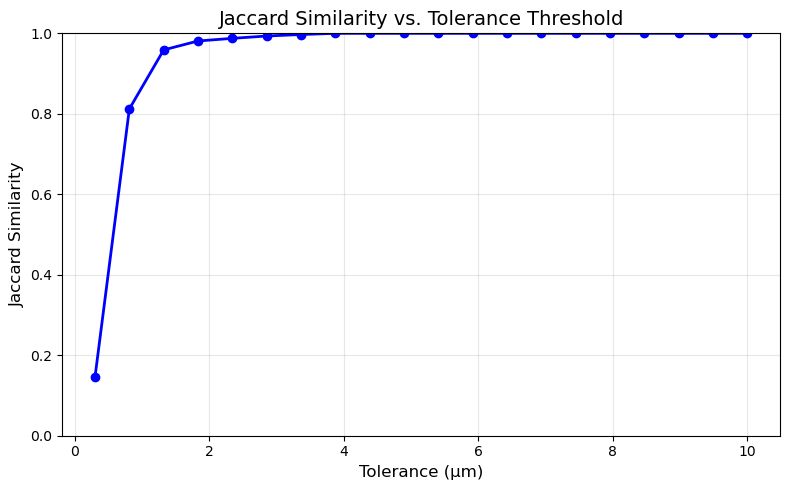

In [13]:
# Compute Jaccard for range of tolerances
tolerances = np.linspace(0.3, 10.0, 20)
original_points = pysnt.tree_to_points(original_tree)
traced_points = pysnt.tree_to_points(fitted_tree)

jaccards = [compute_jaccard_similarity(original_points, traced_points, t) for t in tolerances]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(tolerances, jaccards, 'b-o', linewidth=2, markersize=6)
ax.set_xlabel('Tolerance (µm)', fontsize=12)
ax.set_ylabel('Jaccard Similarity', fontsize=12)
ax.set_title('Jaccard Similarity vs. Tolerance Threshold', fontsize=14)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])
plt.tight_layout()
plt.show()

The graph shows the Jaccard similarity between the original and retraced trees as a function of the spatial tolerance threshold. At very tight tolerances (0.5 µm), similarity is approximately 0.5, indicating that only half of the points align within sub-micron precision. Similarity increases rapidly between 0.5–2 µm, reaching ~0.97 at 1.5 µm, which corresponds roughly to the voxel size of the source image. Beyond 2 µm, similarity plateaus near 1.0, indicating that virtually all traced points lie within 2 µm of their corresponding original points. This steep initial rise followed by saturation suggests the retraced structure closely follows the original reconstruction, with deviations primarily at the sub-voxel scale—consistent with the expected precision of image-based path optimization.

We can also visualize the point-to-point distances between the original and retraced structures:

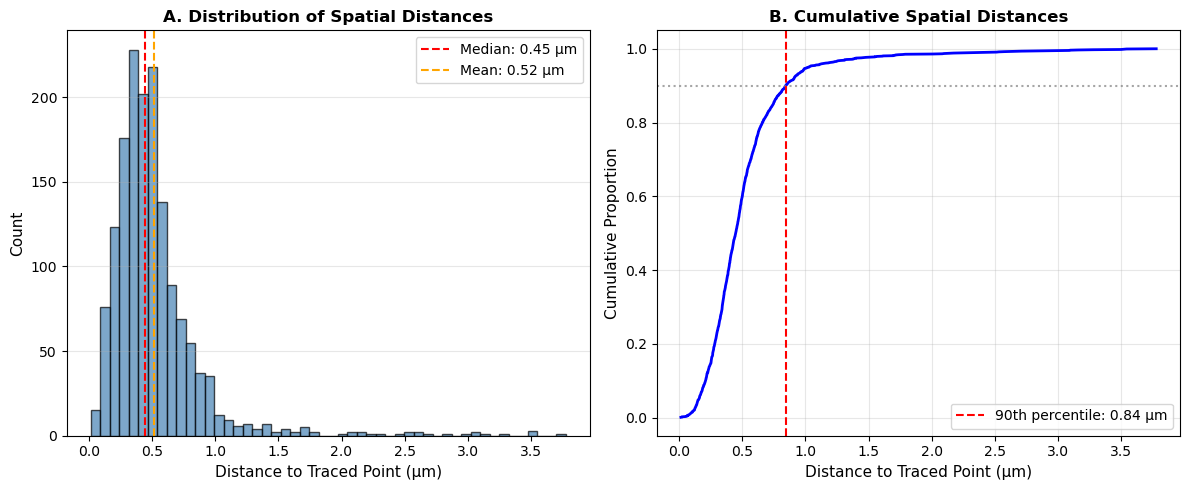

In [14]:
def plot_comparison_metrics(original_points, traced_points, 
                           original_radii=None, traced_radii=None,
                           plot_distances=True, plot_radii=True):
    """
    Plots spatial and/or radii comparisons between original and traced reconstructions.
    
    Parameters
    ----------
    original_points : ndarray
        Original tree coordinates (N × 3). If None, distance plots are skipped.
    traced_points : ndarray
        Traced tree coordinates (M × 3)
    original_radii : ndarray, optional
        Original node radii (N,). If None, radii plots are skipped.
    traced_radii : ndarray, optional
        Traced node radii (M,). If None, radii plots are skipped.
    plot_distances : bool, optional
        If True, plot spatial distance metrics. Default: True
    plot_radii : bool, optional
        If True, plot radius difference metrics (requires radii arrays). Default: True
    
    Returns
    -------
    fig : matplotlib.figure.Figure
    """
    # Determine what to plot
    can_plot_distances = (original_points is not None and traced_points is not None)
    can_plot_radii = (original_radii is not None and traced_radii is not None)
    
    if not can_plot_distances and not can_plot_radii:
        raise ValueError("Must plot at least distances or radii")
    
    # Determine layout
    if can_plot_distances and can_plot_radii:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        metrics = [
            (cKDTree(traced_points).query(original_points)[0], 
             'Distance to Traced Point', 'steelblue', 'Spatial Distances'),
            (np.abs(original_radii[:n] - traced_radii[:n]) if (n := min(len(original_radii), len(traced_radii))) else [],
             'Radius Difference', 'coral', 'Radius Differences')
        ]
    elif can_plot_distances:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes = axes.reshape(1, 2)  # Make 2D for consistent indexing
        metrics = [(cKDTree(traced_points).query(original_points)[0], 
                   'Distance to Traced Point', 'steelblue', 'Spatial Distances')]
    else:  # only radii
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        axes = axes.reshape(1, 2)
        n = min(len(original_radii), len(traced_radii))
        metrics = [(np.abs(original_radii[:n] - traced_radii[:n]),
                   'Radius Difference', 'coral', 'Radius Differences')]
    
    # Plot all metrics
    for i, (data, label, color, title) in enumerate(metrics):
        # Histogram
        ax = axes[i, 0]
        ax.hist(data, bins=50, edgecolor='black', alpha=0.7, color=color)
        ax.axvline(np.median(data), color='red', linestyle='--', 
                   label=f'Median: {np.median(data):.2f} µm')
        ax.axvline(np.mean(data), color='orange', linestyle='--',
                   label=f'Mean: {np.mean(data):.2f} µm')
        ax.set_xlabel(f'{label} (µm)', fontsize=11)
        ax.set_ylabel('Count', fontsize=11)
        ax.set_title(f'{chr(65+i*2)}. Distribution of {title}', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        # CDF
        ax = axes[i, 1]
        sorted_data = np.sort(data)
        cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        ax.plot(sorted_data, cumulative, 'b-', linewidth=2)
        ax.axhline(0.9, color='gray', linestyle=':', alpha=0.7)
        ax.axvline(np.percentile(data, 90), color='red', linestyle='--',
                   label=f'90th percentile: {np.percentile(data, 90):.2f} µm')
        ax.set_xlabel(f'{label} (µm)', fontsize=11)
        ax.set_ylabel('Cumulative Proportion', fontsize=11)
        ax.set_title(f'{chr(65+i*2+1)}. Cumulative {title}', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


fig = plot_comparison_metrics(original_points, traced_points, None, None)
plt.show()


The retraced reconstruction achieves sub-voxel alignment with the original. 

**Panel A** shows most point-to-point distances cluster tightly around 0.3–0.5 µm, with a median of 0.45 µm—approximately equal to the isotropic voxel size (0.48 µm). The right-skewed distribution indicates a small fraction of outliers extending to 2–3 µm perhaps at branch points or low-signal regions. 

**Panel B** confirms that 90% of all nodes lie within 0.81 µm of their nearest counterpart, demonstrating that A* path tracing successfully recovers the original trajectory at the fundamental imaging resolution.


## Refinement: Advanced Adjustments

So far we've only looked at node coordinates. Let's look at their radii:

[main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(12)[0.15 x Gaussian Distribution(0.5389, 0.0664) + 0.19 x Gaussian Distribution(0.5769, 0.0787) + 0.14 x Gaussian Distribution(0.6586, 0.1268) + 0.10 x Gaussian Distribution(0.8182, 0.1457) + 0.09 x Gaussian Distribution(0.9657, 0.1300) + 0.09 x Gaussian Distribution(1.0899, 0.1207) + 0.08 x Gaussian Distribution(1.1988, 0.1180) + 0.06 x Gaussian Distribution(1.3175, 0.1274) + 0.05 x Gaussian Distribution(1.4438, 0.1233) + 0.03 x Gaussian Distribution(1.5529, 0.1128) + 0.02 x Gaussian Distribution(1.6476, 0.1078) + 0.01 x Gaussian Distribution(1.7426, 0.1149)] = -242.9974


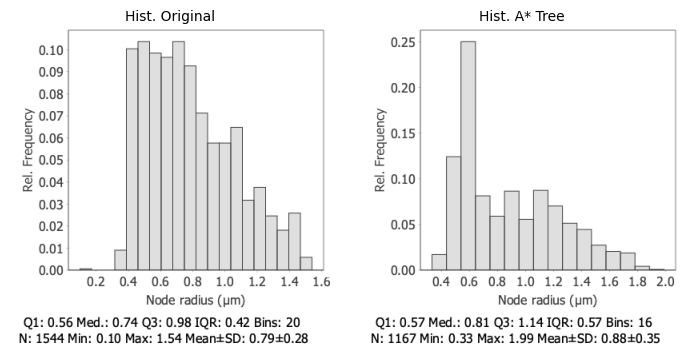

In [15]:
def plot_radii_distributions(trees):
    from pysnt.analysis import TreeStatistics
    hists  = []
    for tree in trees:
        stats = TreeStatistics(tree)
        hist = stats.getHistogram("node radius")
        hists.append(hist)
    pysnt.display(hists)

plot_radii_distributions([original_tree, fitted_tree])

The retraced tree shows a rightward-shifted distribution with larger radii overall. These outliers typically arise at branch points—where cross-sections capture the junction's wider profile, or in regions where signal from adjacent neurites bleeds into the sampling window. The broader IQR (0.57 vs 0.42 µm) and higher standard deviation (0.35 vs 0.28 µm) reflect this contamination.

A practical correction is to identify outliers and replace them with values interpolated from neighboring nodes (You can read more about this approach [here](https://imagej.net/plugins/snt/manual#refinefit-)). This is exactly what {class}`pysnt.Path``.sanitizeRadii()` does. Two variants are available:

- **Predicate-based**: `sanitizeRadii(lambda r: r < 0.6 or r > 2.6, True)` — accepts a lambda function defining invalid radii
- **Range-based**: `sanitizeRadii(0.6, 2.6, True)` — accepts explicit min/max bounds

The boolean `apply` argument controls whether corrections are applied in-place (`True`) or only previewed (`False`). Since we know the valid radius range from the original reconstruction, we'll use the range-based variant:

In [16]:
def sanitize_radii(tree, min_radius, max_radius):
    """
    Fix invalid radii across all paths using interpolation.
    
    Parameters
    ----------
    tree : Tree
        The tree to process
    min_radius : float
        minimum valid radius (inclusive)
    max_radius : float
        maximum valid radius (inclusive)
    
    Returns
    -------
    Tree
        The input tree with fixed radii
    """
    fixed_count = 0
    skipped_paths = [] # Track skipped paths
    
    for path in tree.list():
        
        # sanitizeRadii returns a dictionary of corrected (node index, radius) pairs
        result = path.sanitizeRadii(min_radius, max_radius, True)
        if result is None or len(result) == 0:
        
            # Path has fewer than 2 nodes (no interpolation possible) or
            # no corrections needed (all radii are already within range)
            skipped_paths.append(path)
        else:
            fixed_count += len(result)

    print(f"Fixed {fixed_count} radii across {len(tree.list())-len(skipped_paths)} paths")
    return tree

# Fix radii: Eliminate values outside [0.10, 1.55] µm
fitted_tree = sanitize_radii(fitted_tree, .10, 1.55)

Fixed 69 radii across 16 paths


Several radii were adjusted with interpolated values. Let's look at the new distribution:

[main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(7)[0.19 x Gaussian Distribution(0.5528, 0.0762) + 0.21 x Gaussian Distribution(0.6058, 0.1094) + 0.15 x Gaussian Distribution(0.7336, 0.1650) + 0.12 x Gaussian Distribution(0.9270, 0.1676) + 0.11 x Gaussian Distribution(1.0924, 0.1515) + 0.11 x Gaussian Distribution(1.2369, 0.1451) + 0.10 x Gaussian Distribution(1.3599, 0.1243)] = -89.3491
[main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(8)[0.16 x Gaussian Distribution(0.5439, 0.0692) + 0.20 x Gaussian Distribution(0.5865, 0.0887) + 0.15 x Gaussian Distribution(0.6835, 0.1397) + 0.11 x Gaussian Distribution(0.8539, 0.1523) + 0.10 x Gaussian Distribution(1.0082, 0.1379) + 0.10 x Gaussian Distribution(1.1412, 0.1315) + 0.10 x Gaussian Distribution(1.2695, 0.1311) + 0.08 x Gaussian Distribution(1.3820, 0.1113)] = -81.5542


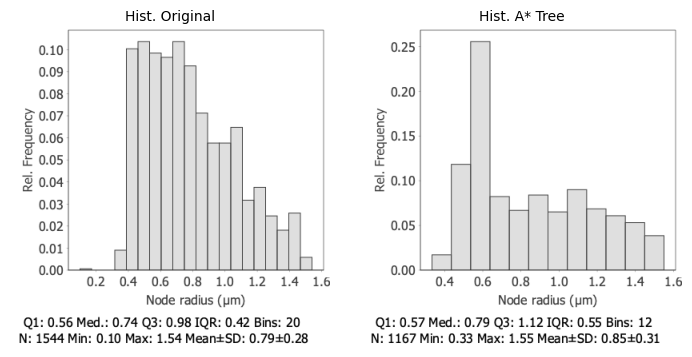

In [17]:
plot_radii_distributions([original_tree, fitted_tree])

The retraced tree now closely matches the original distribution, without the outliers present in earlier iterations. Core statistics show excellent agreement: Q1 (0.57 vs 0.56 µm) and median (0.79 vs 0.74 µm) differ by less than 7%, confirming that the fitting pipeline captures the true neurite thickness.

The slightly broader IQR (0.55 vs 0.42 µm) and higher mean (0.85 vs 0.79 µm) in the traced tree likely reflect methodological differences: cross-sectional intensity fitting tends to estimate slightly larger radii than manual annotation.

Let's look at direct differences:

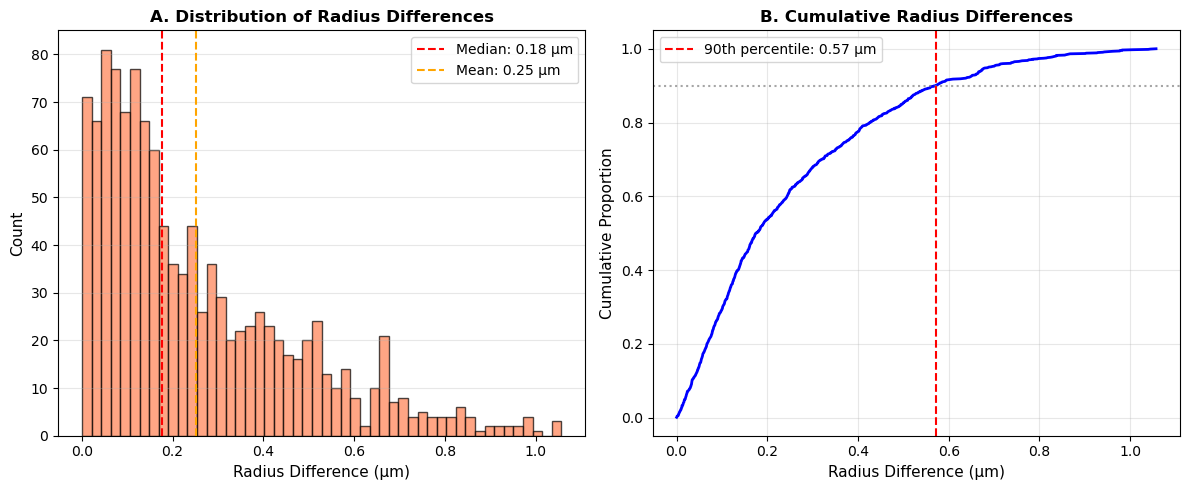

In [18]:
# Extract radii from both trees
original_radii = np.array([node.getRadius() for node in original_tree.getNodes() if node.getRadius() > 0])
fitted_radii = np.array([node.getRadius() for node in fitted_tree.getNodes() if node.getRadius() > 0])

fig = plot_comparison_metrics(None, None, original_radii, fitted_radii)
plt.show()

Once more the fitted radii show strong agreement with the original reconstruction.

**Panel A** Reveals a peak near zero with most differences concentrated below 0.3 µm—approximately 60% of the isotropic voxel size (0.48 µm). The median difference of 0.18 µm indicates that typical radius estimates deviate by less than half a voxel from the ground truth.

**Panel B** The monotonic CDF with a steep initial rise suggests consistent fitting across the reconstruction, without step artifacts that would indicate systematic biases at specific radius values. The right-skewed tail extending to ~1.2 µm reflects residual disagreement at challenging locations—likely branch points or perhaps regions of satured/dim signal.

In [19]:
# Clean up resources
#pysnt.dispose()

## Summary

This tutorial established a programmatic workflow for optimizing neuronal reconstructions by retracing paths through original image data. A strategy complemented by fitting cross-sectional profiles to estimate neurite thickness, and sanitization of outlier radii through interpolation

This workflow is applicable to:

- **Validating** existing reconstructions against image data
- **Refining** coarse or automated tracings
- **Enriching** centerline skeletons with thickness information
- **Generating** high-fidelity ground truth for machine learning pipelines


## Follow-up Questions

1. We used default A* settings throughout. How do different cost functions (e.g., reciprocal vs. difference-based) affect path accuracy and computation time?

2. The radius sanitization used fixed bounds derived from the original reconstruction. How would you determine appropriate bounds for a novel dataset without ground truth? (hint: Search [SNT's manual](https://imagej.net/plugins/snt/manual) for local thickness)

3. Reconstruction accuracy may vary across branch orders (e.g., primary dendrites vs. terminal branches). Would adaptive fitting parameters (e.g., varying cross-section radius, or adapting different fallback strategies on a per branch basis) improve results?


## Data Sources and References

Data used in this notebook is from the [DIADEM Challenge](https://diadem.janelia.org/) dataset. The relevant publications are:

- Brown KM, Barrionuevo G, Canty AJ, et al. The DIADEM data sets: representative light microscopy images of neuronal morphology to advance automation of digital reconstructions. Neuroinformatics. 2011;9(2-3):143-157. doi:[10.1007/s12021-010-9095-5](https://doi.org/10.1007/s12021-010-9095-5)

- Jefferis GS, Potter CJ, Chan AM, et al. Comprehensive maps of Drosophila higher olfactory centers: spatially segregated fruit and pheromone representation. Cell. 2007;128(6):1187-1203. doi:[10.1016/j.cell.2007.01.040](https://doi.org/10.1016/j.cell.2007.01.040)

See [SNT citation](https://imagej.net/plugins/snt/faq#how-do-i-cite-snt) for details on how to properly cite SNT.